<a href="https://colab.research.google.com/github/Wanita-8943/run/blob/main/B3_G3_Train_2e-5_Unfreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [4]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 2850
NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

In [5]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 837, done.
remote: Total 837 (delta 0), reused 0 (delta 0), pack-reused 837
Receiving objects: 100% (837/837), 13.85 MiB | 37.83 MiB/s, done.
Resolving deltas: 100% (497/497), done.
/content/efficientnet_keras_transfer_learning


In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB3 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [7]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


43966704/43966704 [==============================] - 1s 0us/step


In [8]:
base_dir = '/content/drive/MyDrive/TVT_Gender'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

#load model

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/cut_panoramic/Model/B3_G2_2e-5_250.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [10]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/cut_panoramic/Model/B3_G2_2e-5_250.h5')
height = width = model.input_shape[1]

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 5, 5, 1536)       10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 3074      
                                                                 
Total params: 10,786,602
Trainable params: 3,074
Non-trainable params: 10,783,528
_________________________________________________________________


In [12]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2850 images belonging to 2 classes.
Found 950 images belonging to 2 classes.


In [13]:
# multiply_16
# set 'multiply_16' and following layers trainable
model.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False  

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 5, 5, 1536)       10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 3074      
                                                                 
Total params: 10,786,602
Trainable params: 10,699,306
Non-trainable params: 87,296
_________________________________________________________________


In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-15-caa7b37242a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
178/178 [==============================] - 125s 617ms/step - loss: 0.6229 - acc: 0.6591 - val_loss: 0.6392 - val_acc: 0.6314
Epoch 2/250
178/178 [==============================] - 24s 134ms/step - loss: 0.6236 - acc: 0.6574 - val_loss: 0.6263 - val_acc: 0.6345
Epoch 3/250
178/178 [==============================] - 24s 132ms/step - loss: 0.6212 - acc: 0.6507 - val_loss: 0.6377 - val_acc: 0.6335
Epoch 4/250
178/178 [==============================] - 24s 132ms/step - loss: 0.6138 - acc: 0.6694 - val_loss: 0.6162 - val_acc: 0.6547
Epoch 5/250
178/178 [==============================] - 24s 132ms/step - loss: 0.6206 - acc: 0.6591 - val_loss: 0.6367 - val_acc: 0.6335
Epoch 6/250
178/178 [==============================] - 24s 135ms/step - loss: 0.6218 - acc: 0.6440 - val_loss: 0.6501 - val_acc: 0.6165
Epoch 7/250
178/178 [==============================] - 24s 134ms/step - loss: 0.6242 - acc: 0.6521 - val_loss: 0.6448 - val_acc: 0.6239
Epoch 8/250
178/178 [==========================

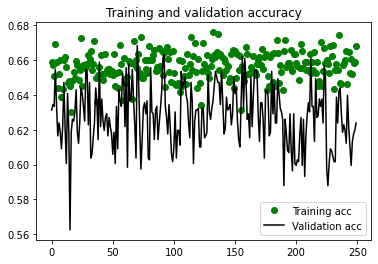

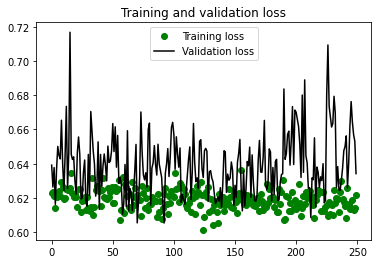

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'go', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model

In [17]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/B3_G3_2e-5_250_Un.h5')

In [18]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/2_รอบที่2_Gender_250.h5')